In [1]:
import json
import datetime
import os
import time
import sys

import pandas as pd
import numpy as np
from sklearn import preprocessing

import matplotlib.pyplot as plt

sys.path.append('..')
from preprocessing import load, process, preprocess_and_save
from aggregation import ohe_explicit

# Loading the data

The file *preprocessing.py* contains function to load the JSON data, convert to Pandas DataFrames, and perform basic preprocessing (e.g., delete columns that are constant). 

In [64]:
train = load("../data/train.csv")

const_cols = [c for c in train.columns if train[c].nunique(dropna=False) == 1]
train = train.drop(const_cols, axis=1)

# Cast target
train["transactionRevenue"] = train["transactionRevenue"].fillna(0).astype(float)

Loaded file ../data/train.csv
Shape is: (903653, 55)


## Hypothesis: certain profiles should be naively assigned a zero predicted revenue

Since the new problem description includes much less information at prediction time (no session info) it might be beneficial to only focus on visitors with a high probability to spend - and assign a zero prediction to everyone else.

**Which profile is improbable enough to make a purchase, that it makes sense to make that prediction naively?**

We think that visitors with a single visit that did not lead to a purchase during the training period (prior to December of the testing year) have a very high probability of not buying anything during December and January either. Let's test this assumption.

In [65]:
x_train = train[(train["date"] < '2016-12-01')]
y_train = train[(train["date"] >= '2016-12-01') & (train["date"] >= '2017-02-01')]

In [66]:
# Find people with a single visit during the training period
count = x_train[["fullVisitorId", "transactionRevenue"]].groupby("fullVisitorId").count().reset_index()

single_visit_ids = count[count["transactionRevenue"] == 1]["fullVisitorId"]
print("There are {} such visitors (out of {} found in our training set in total).".format(len(single_visit_ids), len(count)))

There are 263866 such visitors (out of 295432 found in our training set in total).


In [67]:
# But maybe some of those guys actually bought something in that single visit.
single_visits = x_train[x_train["fullVisitorId"].isin(single_visit_ids)]
num_purchases = len(single_visits[single_visits["transactionRevenue"] > 0]["transactionRevenue"])
print("Out of {} single visits, {} ended up in a purchase".format(len(single_visit_ids), num_purchases))

Out of 263866 single visits, 1107 ended up in a purchase


In [68]:
to_ignore = set(single_visit_ids) - set(single_visits[single_visits["transactionRevenue"] > 0]["fullVisitorId"])
print("We will therefore choose to ignore {} users".format(len(to_ignore)))

We will therefore choose to ignore 262759 users


## Is this assumption justified?

How reliable is this assumption? Are these people that we choose to ignore indeed buying nothing? Let's find out.


In [72]:
# We will only focus on people who exist in both datasets
common_ids = set(y_train["fullVisitorId"]).intersection(x_train["fullVisitorId"])
print("There are {} people appearing both in the training and the test periods".format(len(common_ids)))

y_train = y_train[y_train["fullVisitorId"].isin(common_ids)]
ignored = y_train[y_train["fullVisitorId"].isin(to_ignore)]
print("We will ignore {} out of those {} people".format(len(ignored), len(common_ids)))

There are 2290 people appearing both in the training and the test periods
We will ignore 2037 out of those 2290 people


In [88]:
import numpy as np

predicted_target = [0] * len(common_ids)

y_train_grouped = y_train[["fullVisitorId", "transactionRevenue"]].groupby("fullVisitorId", as_index=False).sum()
actual_target = y_train_grouped["transactionRevenue"].apply(lambda revenue: np.log(revenue + 1))
    
loss = np.sqrt(np.mean((predicted_target - actual_target)**2))
num_mistakes = sum(actual_target > 0)

print("We made {} mistakes ({:.2f}% of cases) leading to loss = {}".format(num_mistakes, 100*num_mistakes/len(ignored) ,loss))

We made 196 mistakes (9.62% of cases) leading to loss = 5.4433800738203315


## Is this small enough?

That's not a neglilible mistake: 196 out of 2037 people and a loss of 5 in the log space. However we do not yet know what a predictive model would be able to predict (without any session information of course). If a model would be able to do better, then its of course a bad idea to ignore these guys. If the predictive model fails, then its a good idea to ignore them.

**To be continued!**

In [89]:
# Run this if you need to recreate the initial dataset
#preprocess_and_save("../data", nrows_train=100000, nrows_test=10000)

# Categoricals with many values

There are a number of categorical features with many different values. This is an issue, specifically in the cases where those categorical features are not ordinal, and therefore label encoding them does not make sense. The only choice we are left with, is OHE. However naively performing this step would add hundreds of columns for each original categorical feature - in the end yielding potentially thousands of super sparse features. What I would like to explore, is whether there exist **specific values** with predictive value significantly higher than average. For example, looking at the particular country might be a weak predictor. However there might be 5 specific countries with a huge revenue deviation from the average (and enough samples to consider this discrepancy statistically significant).

In [93]:
train = load("../data/train.csv")
test = load("../data/test.csv", nrows=10000)
train, test = process(train, test)

countries = train['country']
print("There are {} different countries in our dataset".format(len(countries.unique())))

Loaded file ../data/train.csv
Shape is: (903653, 55)
Loaded file ../data/test.csv
Shape is: (10000, 53)
Dropping constant columns...
Create some features...
Generating date columns...
Finding total visits...
Splitting back...
There are 222 different countries in our dataset


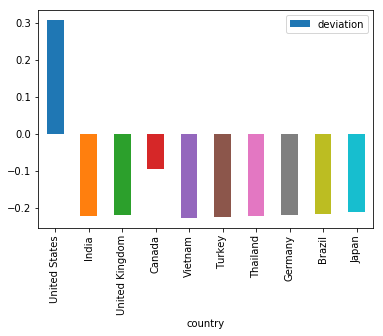

In [94]:
aggregations = {'target':['mean', 'count']}

countries = train[["country", "target"]].groupby("country", as_index=False).agg(aggregations)
countries.columns = ["country", "targetMean", "occurenceCount"]

# Let's focus only on countries with multiple records to preserve some statistical significance
keep = 10
usual_countries = countries.sort_values("occurenceCount", ascending=False).head(keep)

global_average = train["target"].mean()
usual_countries["deviation"] = usual_countries["targetMean"] - global_average
usual_countries.plot.bar(x="country", y="deviation")

# USA seems quite different

What we can find here is that USA is very different to any other country with significant sample count. What we can do with this information? We instead of using OHE to code every country in our dataset, we can probably get away with a single boolean column: **is this record coming from the USA?**

In [95]:
cities = train['city']
print("There are {} different cities in our dataset".format(len(cities.unique())))

There are 648 different cities in our dataset


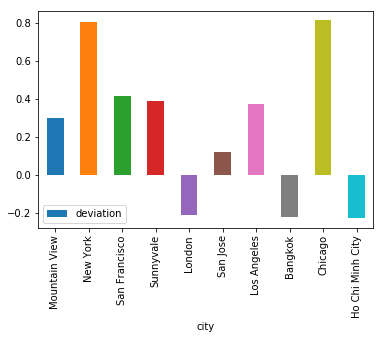

In [96]:
aggregations = {'target':['mean', 'count']}

cities = train[["city", "target"]].groupby("city", as_index=False).agg(aggregations)
cities.columns = ["city", "targetMean", "occurenceCount"]

# Let's focus only on countries with multiple records to preserve some statistical significance
keep = 10
usual_cities = cities.sort_values("occurenceCount", ascending=False).head(keep)

global_average = train["target"].mean()
usual_cities["deviation"] = usual_cities["targetMean"] - global_average
usual_cities.plot.bar(x="city", y="deviation")

# What about the cities?

Here we can see some pretty strong deviations. However we need to note that the top ones come from US cities, so part of the variance these cities explain, is already included in the information that they belong to the USA. However their deviation is considerably higher than that of USA alone (1.0 vs 0.3) so including those columns might still be beneficial. The deviation we see is actually very distorted because of the USA outlier. Perhaps it would make more sense to only focus on the deviation from the average of non-USA cities.

In [97]:
train_not_us = train[train['country'] != "United States"]
train_us = train[train['country'] == "United States"]

outside_us_avg = train_not_us['target'].mean()
us_avg = train_us["target"].mean()

print("Average in US: {}\nAverage outside US: {}".format(us_avg, outside_us_avg))

Average in US: 0.5350073082967423
Average outside US: 0.01873286818644981


**Let's then repeat out analysis but this time separatly for the pieces of data**

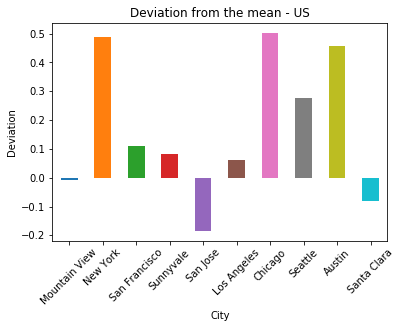

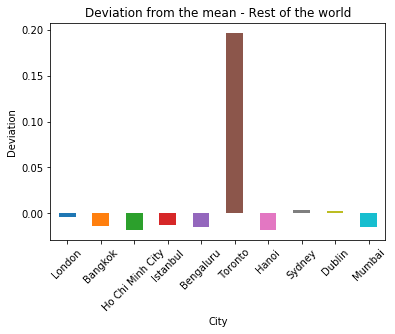

In [98]:
aggregations = {'target':['mean', 'count']}

# US case
def city_deviation(df, title="Deviation per city"):
    cities = df[["city", "target"]].groupby("city", as_index=False).agg(aggregations)
    cities.columns = ["city", "targetMean", "occurenceCount"]

    # Let's focus only on countries with multiple records to preserve some statistical significance
    keep = 10
    usual_cities = cities.sort_values("occurenceCount", ascending=False).head(keep)

    global_average = df["target"].mean()
    usual_cities["deviation"] = usual_cities["targetMean"] - global_average
    ax = usual_cities.plot.bar(x="city", y="deviation", title=title, rot=45, legend=False)
    ax.set_xlabel("City")
    ax.set_ylabel("Deviation")
    
city_deviation(train_us, title="Deviation from the mean - US")
city_deviation(train_not_us, title="Deviation from the mean - Rest of the world")

## Much better!

Now we can clearly see what information should be included besides the country (or to be exact, whether or not the country is the US). For example it makes no sense to include Los Angeles or Mountain View even though they deviate from the global average, because all this deviation is explained by the fact that they exist in the US! Instead we should include Chicago, New York, Austin, Seattle and maybe Palo Alto. And as we can see the deviations are much smaller outside the US, with the exception of Toronto which MUST be included.

### Food for thought
It makes sense that deviations outside the US are smaller because the target itself is considerable lower. Perhaps we should look at relative deviations instead?

In [99]:
check = ohe_explicit(train)
check.head()  

,channelGrouping,date,fullVisitorId,visitNumber,browser,deviceCategory,isMobile,operatingSystem,continent,metro,...,weekday,visitHour,totalVisits,country_United States,city_New York,city_Chicago,city_Austin,city_Seattle,city_Palo Alto,city_Toronto
0,Organic Search,2016-09-02,1131660440785968503,1,Chrome,desktop,False,Windows,Asia,NaN,...,4,17,1,False,False,False,False,False,False,False
1,Organic Search,2016-09-02,377306020877927890,1,Firefox,desktop,False,Macintosh,Oceania,NaN,...,4,7,1,False,False,False,False,False,False,False
2,Organic Search,2016-09-02,3895546263509774583,1,Chrome,desktop,False,Windows,Europe,NaN,...,4,3,1,False,False,False,False,False,False,False
3,Organic Search,2016-09-02,4763447161404445595,1,UC Browser,desktop,False,Linux,Asia,NaN,...,4,7,1,False,False,False,False,False,False,False
4,Organic Search,2016-09-02,27294437909732085,2,Chrome,mobile,True,Android,Europe,NaN,...,4,15,2,False,False,False,False,False,False,False
